## Lab 11d: Online Planning in the Lava Grid World
This lab will familiarize students with the `rollout` solution of a `two-dimensional` navigation problem, i.e., a lava world [roomba](https://www.irobot.com) problem. We'll use a `rollout` approach, a random policy for exploring the world. See `Algorithm 9.1` of the [Decisions Book](https://algorithmsbook.com).

### Problem
You have a [roomba](https://www.irobot.com) that has finished cleaning the kitchen floor and needs to return to its charging station. However, between your kitchen floor and the `charging station` (safety), there are one or more `lava pits` (destruction for the [roomba](https://www.irobot.com)). This is an example of a two-dimensional grid-world navigational decision task. 

### Objectives and tasks
This example will familiarize students with using `rollout` for solving a two-dimensional grid-world navigation task, the role of the discount factor $\gamma$. In particular, we will:

* __Task 1__: Build a `n` $\times$ `n` world model with two lava pits and a charging station.
* __Task 2__: Generate the components of the MDP problem 
* __Task 3__: Develop on online planning solution by implementing a `rollout(...)` method.

## Setup
We set up the computational environment by including [the `Include. jl` file](Include.jl) using [the `include(...)` method](https://docs.julialang.org/en/v1/base/base/#Base.include). The [`Include.jl` file](Include.jl) loads external packages and functions we will use in these examples. 
* For additional information on functions and types used in this example, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

In [3]:
include("Include.jl");

In [4]:
function rbf(x::Tuple{Int,Int},y::Tuple{Int,Int}; σ = 1.0)::Float64
    d = sqrt((x[1] - y[1])^2 + (x[2] - y[2])^2);
    return exp(-d/(2*σ^2))
end;

## Task 1: Build the world model
We encoded the `rectangular grid world` using the `MyRectangularGridWorldModel` model, which we construct using a `build(...)` method. Let's setup the data for the world, setup the states, actions, rewards and then construct the world model. 
* First, set values for the `number_of_rows` and `number_of_cols` variables, the `nactions` that are avialble to the agent and the `discount factor` $\gamma$. 
* Then, we'll compute the number of states, and setup the state set $\mathcal{S}$ and the action set $\mathcal{A}$

In [6]:
number_of_rows = 10
number_of_cols = 10
nactions = 4;
γ = 0.2;
number_of_random_steps = 64;
nstates = (number_of_rows*number_of_cols);
𝒮 = range(1,stop=nstates,step=1) |> collect;
𝒜 = range(1,stop=nactions,step=1) |> collect;

Next, we'll set up a description of the rewards, the `rewards::Dict{Tuple{Int,Int}, Float64}` dictionary, which maps the $(x,y)$-coordinates to a reward value. We only need to put `non-default` reward values in the reward dictionary (we'll add default values to the other locations later). Lastly, let's put the locations on the grid that are `absorbing`, meaning the charging station or lava pits in your living room:

In [8]:
# setup rewards -
lava_reward = -1000.0;
charging_reward = 100.0;
softwall_reward = -2000.0;
σ = 1.0;
default_reward = -0.1;
charging_station_coordinates = (1,3);

rewards = Dict{Tuple{Int,Int}, Float64}()
rewards[(2,2)] = lava_reward # lava in the (2,2) square 
rewards[(4,4)] = lava_reward # lava in the (4,4) square
rewards[charging_station_coordinates] = charging_reward    # charging station square

# walls?
soft_wall_set = Set{Tuple{Int,Int}}(); # none for now ...

# setup set of absorbing states -
absorbing_state_set = Set{Tuple{Int,Int}}()
push!(absorbing_state_set, (2,2));
push!(absorbing_state_set, charging_station_coordinates);
push!(absorbing_state_set, (4,4));

### Reward shaping
In cases where rewards are sparse, there are only a few $(s, a)$ pairs that lead to non-zero rewards. This is an issue because reinforcement learning algorithms, e.g., `Q-learning,` behave randomly initially when the action-value function $Q(s, a)$ is unknown. 

* [Reward shaping](https://gibberblot.github.io/rl-notes/single-agent/reward-shaping.htmlhttps://gibberblot.github.io/rl-notes/single-agent/reward-shaping.html) is an approach to address this issue, by modifying the reward function to promote behavior that we think will move us closer to the goal state, e.g., the `charging_station.` There are different approaches to this. We'll use a [radial basis kernel function](https://en.wikipedia.org/wiki/Radial_basis_function_kernel) to radiate charging station rewards from the goal state.

In [10]:
# do some shaping?
is_reward_shaping_on = true;
if (is_reward_shaping_on == true)
    for s in 𝒮
        for s′ in 𝒮
            coordinate = (s,s′);
            if (haskey(rewards, coordinate) == false && in(coordinate,soft_wall_set) == false && 
                    in(coordinate,absorbing_state_set) == false)
                rewards[coordinate] = default_reward + charging_reward*rbf(coordinate, charging_station_coordinates, σ = σ);
            end
        end
    end
end

Finally, we can build an instance of the `MyRectangularGridWorldModel` type, which models the grid world. We save this instance in the `world` variable
* We must pass in the number of rows `nrows`, number of cols `ncols`, and our initial reward description in the `rewards` field into the `build(...)` method

In [12]:
world = VLDecisionsPackage.build(MyRectangularGridWorldModel, 
    (nrows = number_of_rows, ncols = number_of_cols, rewards = rewards));

In [13]:
world.states[charging_station_coordinates] |> i -> world.rewards[i]

100.0

## Task 2: Generate the components of the MDP problem
The MDP problem requires the return function (or array) `R(s, a)`, and the transition function (or array) `T(s, s′, a)`. Let's construct these from our grid world model instance, starting with the reward function `R(s, a)`:

### Rewards $R(s,a)$
We'll encode the reward function as a $\dim\mathcal{S}\times\dim\mathcal{A}$ array, which holds the reward values for being in state $s\in\mathcal{S}$ and taking action $a\in\mathcal{A}$. After initializing the `R`-array and filling it with zeros, we'll populate the non-zero values of $R(s, a)$ using nested `for` loops. During each iteration of the `outer` loop, we'll:
* Select a state `s`, an action `a`, and a move `Δ`
* We'll then compute the new position resulting from implementing action `a` from the current position and store this in the `new_position` variable. * If the `new_position`$\in\mathcal{S}$ is in our initial `rewards` dictionary (the charging station or a lava pit), we use that reward value from the `rewards` dictionary. If we are still in the world but not in a special location, we set the reward to `-1`.
* Finally, if `new_position`$\notin\mathcal{S}$, i.e., the `new_position` is a space outside the grid, we set a penalty of `-50000.0`.

In [15]:
R = zeros(nstates, nactions);
fill!(R, 0.0)
for s ∈ 𝒮
    for a ∈ 𝒜
        
        Δ = world.moves[a];
        current_position = world.coordinates[s]
        new_position =  current_position .+ Δ
        if (haskey(world.states, new_position) == true)
            if (haskey(rewards, new_position) == true)
                R[s,a] = rewards[new_position];
            else
                R[s,a] = -1.0;
            end
        else
            R[s,a] = -50000.0; # we are off the grid, big negative penalty
        end
    end
end
R

100×4 Matrix{Float64}:
 -50000.0           32.5922    -50000.0           60.5531
 -50000.0        -1000.0           36.6879       100.0
 -50000.0           60.5531        60.5531        60.5531
 -50000.0           49.2069       100.0           36.6879
 -50000.0           32.5922        60.5531        22.213
 -50000.0           20.4741        36.6879        13.4335
 -50000.0           12.6256        22.213          8.1085
 -50000.0            7.712         13.4335         4.87871
 -50000.0            4.67689        8.1085         2.91974
 -50000.0            2.81432        4.87871   -50000.0
     36.6879        24.2117    -50000.0        -1000.0
     60.5531        32.5922        32.5922        60.5531
    100.0           36.6879     -1000.0           49.2069
      ⋮                                       
      0.895409       0.347913       0.794205       0.391692
      0.60852        0.234303       0.573795  -50000.0
      1.51941   -50000.0       -50000.0            0.980558
      1.6

### Transition $T(s, s^{\prime},a)$
Next, build the transition function $T(s,s^{\prime},a)$. We'll encode this as a $\dim\mathcal{S}\times\dim\mathcal{S}\times\dim\mathcal{A}$ [multidimension array](https://docs.julialang.org/en/v1/manual/arrays/) and populate it using nested `for` loops. 

* The `outer` loop we will iterate over actions. For every $a\in\mathcal{A}$ will get the move associated with that action and store it in the `Δ`
* In the `inner` loop, we will iterate over states $s\in\mathcal{S}$. We compute a `new_position` resulting from implementing action $a$ and check if `new_position`$\in\mathcal{S}$. If `new_position` is in the world, and `current_position` is _not_ an `absorbing state` we set $s^{\prime}\leftarrow$`world.states[new_position]`, and `T[s, s′,  a] = 1.0`
* However, if the `new_position` is outside of the grid (or we are jumping from an `absorbing` state), we set `T[s, s,  a] = 1.0`, i.e., the probability that we stay in `s` if we take action `a` is `1.0`.

In [17]:
T = Array{Float64,3}(undef, nstates, nstates, nactions);
fill!(T, 0.0)
for a ∈ 𝒜
    
    Δ = world.moves[a];
    
    for s ∈ 𝒮
        current_position = world.coordinates[s]
        new_position =  current_position .+ Δ
        if (haskey(world.states, new_position) == true && 
                in(current_position, absorbing_state_set) == false)
            s′ = world.states[new_position];
            T[s, s′,  a] = 1.0
        else
            T[s, s,  a] = 1.0
        end
    end
end

Finally, we construct an instance of the `MyMDPProblemModel` which encodes the data required to solve the MDP problem.
* We must pass the states `𝒮`, the actions `𝒜`, the transition matrix `T`, the reward matrix `R`, and the discount factor `γ` into the `build(...)` method. We store the MDP model in the `m` variable:

In [19]:
m = VLDecisionsPackage.build(MyMDPProblemModel, 
    (𝒮 = 𝒮, 𝒜 = 𝒜, T = T, R = R, γ = γ));

## Task 3: Online planning solution
First, let's set the `depth` that are going to explore, i.e., how many steps are we going to take when exploring each state `s`:

In [21]:
d = number_of_random_steps;

Next, let's implement three functions:

> The `myrandpolicy(problem::MyMDPProblemModel, world::MyRectangularGridWorldModel, s::Int) -> Int` function takes a `MyMDPProblemModel` instance, a `MyRectangularGridWorldModel` instance and the state `s`. This function returns a random action $a\in\mathcal{A}$.

> The `myrandstep(problem::MyMDPProblemModel, world::MyRectangularGridWorldModel, s::Int, a::Int)` function takes a `MyMDPProblemModel` instance, a `MyRectangularGridWorldModel` instance, the state `s` and an action `a` and returns the next state $s^{\prime}$ and reward $r$.

> The `myrollout(problem::MyMDPProblemModel, world::MyRectangularGridWorldModel, s::Int64, depth::Int64) -> Float64` function takes a `MyMDPProblemModel` instance, a `MyRectangularGridWorldModel` instance, the state `s` and the depth `d`. This function returns the cumulative reward after exploring the network for `d` steps.

These implementations were based on `Algorithm 9.1` of the [Decisions Book](https://algorithmsbook.com)

In [23]:
function myrandpolicy(problem::MyMDPProblemModel, 
        world::MyRectangularGridWorldModel, s::Int)::Int
    
    # initialize -
    d = Categorical([0.25,0.25,0.25,0.25]); # you specify this LRDU
    
    # should keep choosing -
    should_choose_again = true;
    a = 1; # default
    while (should_choose_again == true)
       
        # initialize a random categorical distribution over actions -
        aᵢ = rand(d);
        
        # get the move and the current location -
        Δ = world.moves[aᵢ];
        current_position = world.coordinates[s]
        new_position =  current_position .+ Δ
        if (haskey(world.states, new_position) == true)
            a = aᵢ
            should_choose_again = false;
        end
    end
    
    return a;
end;

In [24]:
function myrandstep(problem::MyMDPProblemModel, 
        world::MyRectangularGridWorldModel, s::Int, a::Int)
    
    r = problem.R[s,a]; # get the reward value for being in state s, and taking action a
    Δ = world.moves[a]; # this action does this move    
    current_position = world.coordinates[s]; # get where we are now
    new_position =  current_position .+ Δ; # propose a new position
    
    s′ = s; # default, we don't do anything, stay where you are
    if (haskey(world.states, new_position) == true)
        s′ = world.states[new_position];
    end
    
    # return -
    return (s′,r) # This returns the next state and the reward at the current position
end;

In [25]:
function myrollout(problem::MyMDPProblemModel, 
        world::MyRectangularGridWorldModel, s::Int64, depth::Int64)::Float64
    
    # initialize -
    ret = 0.0;
    γ = problem.γ;
    visited_states = Set{Int64}();
    is_ok_to_stop = false;
    i = 1;

    while (is_ok_to_stop == false)
       
        a = myrandpolicy(problem, world, s);
        s, r = myrandstep(problem, world, s, a);

        if (s ∉ visited_states)
            push!(visited_states, s);
            ret += r*γ^(i-1);
            i += 1;

            # can we stop?
            if (length(visited_states) ≥ depth)
                is_ok_to_stop = true;
            end
        end
    end    
    
    # for i ∈ 1:depth
    #     a = myrandpolicy(problem, world, s);
    #     s, r = myrandstep(problem, world, s, a);
    #     ret += r*γ^(i-1);
    # end
    return ret;
end;

In [26]:
U(s) = myrollout(m,world,s,d);

We use a `for loop` to compute the value (utility) starting from each state in the system. For each state $s\in\mathcal{S}$, we call the `myrollout(...)` function, which explores the system to a depth `d`, returns the value (utility) at state `s,` and saves the value in the `utility_array::Array{Float64,1}`.

In [28]:
utility_array = Array{Float64,1}();
for s ∈ 𝒮
    push!(utility_array, U(s))
end

Extract the `action-value function` or $Q(s, a)$ from the `utility_array`. We can do this using the `Q(...)` function, which takes `m` and the `utility_array`:

In [30]:
my_Q = Q(m, utility_array)

100×4 Matrix{Float64}:
 -49989.7         -212.656     -49989.7           68.918
 -49991.6        -1046.74          46.9845       114.063
 -49985.9           74.6158        74.6158        74.6158
 -49970.1           60.804        114.063         44.2345
 -49992.5           33.2272        90.4728        28.279
 -49993.9           30.059         44.2345        18.1391
 -49995.3           17.7703        28.279         10.6415
 -49997.5           11.5169        18.1391         7.84224
 -49997.0            7.26345       10.6415         3.89846
 -49999.0            4.49302        7.84224   -49999.0
     46.9845        33.9341    -50245.2        -1046.74
     13.8178       -14.1431       -14.1431        13.8178
    114.063         58.9457     -1046.74          60.804
      ⋮                                       
      1.08243        0.519354       1.15568        0.485968
      0.756563       0.346886       0.716391  -49999.9
      2.265     -49999.5       -49999.5            1.29812
      2.2

Finally, we can extract the policy $\pi(s)$ from the action-value function $Q(s,a)$ using the `policy(...)` function:

In [32]:
my_π = policy(my_Q);

In [33]:
my_π

100-element Vector{Int64}:
 4
 4
 2
 3
 3
 3
 3
 3
 3
 3
 1
 1
 1
 ⋮
 3
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 3

In [34]:
# save a good policy, just in case we can't find one later -
# save("Good-policy.jld2",Dict("policy"=>my_π))

### Visualize
`Unhide` the code block below to see how we plot the path from a `startstate` to (potentially) one of the absorbing states. The charging station is show in green, while the lava pits are shown in red. Specify the `startstate` coordinate tuple:

In [91]:
 startstate = (10,1);

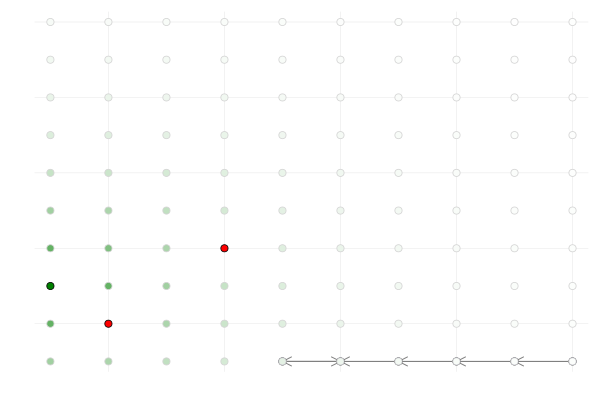

In [92]:
let

    # setup 
    world_model = world;
   
    # draw the path -
    p = plot();
    initial_site = startstate
    hit_absorbing_state = false
    s = world_model.states[initial_site];
    visited_sites = Set{Tuple{Int,Int}}();
    push!(visited_sites, initial_site);

    s′ = s;
    while (hit_absorbing_state == false)
        
        current_position = world_model.coordinates[s′]
        a = my_π[s′];
        Δ = world_model.moves[a];
        new_position =  current_position .+ Δ
        scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, msc=:black, c=:blue)
        plot!([current_position[1], new_position[1]],[current_position[2],new_position[2]], label="", arrow=true, lw=1, c=:gray)

        s′ = nothing;
        if (in(new_position, absorbing_state_set) == true || in(new_position, visited_sites) == true)
            hit_absorbing_state = true;
        elseif (haskey(world_model.states, new_position) == true)
            s′ = world_model.states[new_position];
            push!(visited_sites, new_position);
        else
            hit_absorbing_state = true; 
        end
    end

    # draw the grid -
    for s ∈ 𝒮
        current_position = world_model.coordinates[s]
        a = my_π[s];
        Δ = world_model.moves[a];
        new_position =  current_position .+ Δ
        
         if (haskey(rewards, current_position) == true && rewards[current_position] == charging_reward)
            scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, c=:green, ms=4)
        elseif (haskey(rewards, current_position) == true && rewards[current_position] == lava_reward)
            scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, c=:red, ms=4)
        elseif (in(current_position, soft_wall_set) == true)
            scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, c=:gray69, ms=4)
        else
            if (is_reward_shaping_on == true)
                new_color = weighted_color_mean(rbf(current_position, charging_station_coordinates, σ = σ), colorant"green", colorant"white")
                scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, msc=:lightgray, c=new_color)
            else
                scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, msc=:black, c=:white)
            end
        end
    end
    current()
end

In [93]:
# let

#     move_arrows = Dict{Int,Any}();
#     move_arrows[1] = "←"
#     move_arrows[2] = "→"
#     move_arrows[3] = "↓"
#     move_arrows[4] = "↑"
#     move_arrows[5] = "∅";

#     for s ∈ 𝒮
#         a = my_π[s];
#         Δ = world.moves[a];
#         current_position = world.coordinates[s]
#         new_position =  current_position .+ Δ
        
#         if (in(current_position, absorbing_state_set) == true)
#             println("$(current_position) $(move_arrows[5])")
#         else
#             println("$(current_position) $(move_arrows[a]) $(new_position)")
#         end
#     end
# end